In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import astropy.constants as ac
import matplotlib.pyplot as plt
import os
import joblib

In [ ]:
# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Constants
GMsun = ac.GM_sun.value  # G*(Solar Mass)
c = ac.c.value  # Speed of light in vacuum
dsun = GMsun / (c**2)  # Natural length scale
tsun = GMsun / (c**3)  # Natural time scale
pc = ac.pc.value  # One parsec
yr = (365.25) * (24) * (60) * (60)
tsun = torch.tensor(tsun)
yr = torch.tensor(yr)  # Seconds in one year

# Data directory
datadir = "./"

# Load data
data_tensor = torch.load(f"{datadir}/data.pt")  # Shape: (1_000_000, 7)

# Split into inputs (first 5 columns) and outputs (last 2 columns)
X_raw = data_tensor[:, :5]  # Shape: (1_000_000, 5)
y_raw = data_tensor[:, 5:]  # Shape: (1_000_000, 2)

# Move to device safely
X_raw = X_raw.clone().detach().to(device)
y_raw = y_raw.clone().detach().to(device)

# Preprocessing
# Scale inputs (X)
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_raw.cpu().numpy())  # sklearn expects CPU numpy arrays
X = torch.tensor(X_scaled, dtype=torch.float32).to(device)

# Transform outputs y: [log10(omega), phi]
y_transformed = torch.stack([
    torch.log10(y_raw[:, 0]),  # log10(omega)
    y_raw[:, 1]                # phi
], dim=1)

# Scale outputs (y)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_transformed.cpu().numpy())
y = torch.tensor(y_scaled, dtype=torch.float32).to(device)

In [ ]:
# Set seed
torch.manual_seed(42)

# Split into train and test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Wrap in TensorDataset and DataLoader
batch_size = 1024
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define ANN model
class ANN(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=2, num_hidden=4):
        super(ANN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_hidden - 1):
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Instantiate model, loss, optimizer, and scheduler
model = ANN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Decay LR by 0.1 every 20 epochs

In [8]:
# Training loop with validation
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Store training loss
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            val_predictions = model(X_batch)
            val_loss += criterion(val_predictions, y_batch).item() * X_batch.size(0)
    val_loss /= len(test_dataset)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step()
    if epoch % 10 == 0:
    # Print progress
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

Epoch 1/100, Train Loss: 0.000204, Val Loss: 0.000156
Epoch 11/100, Train Loss: 0.000144, Val Loss: 0.000351
Epoch 21/100, Train Loss: 0.000024, Val Loss: 0.000101
Epoch 31/100, Train Loss: 0.000021, Val Loss: 0.000018
Epoch 41/100, Train Loss: 0.000014, Val Loss: 0.000012
Epoch 51/100, Train Loss: 0.000013, Val Loss: 0.000012
Epoch 61/100, Train Loss: 0.000013, Val Loss: 0.000012
Epoch 71/100, Train Loss: 0.000013, Val Loss: 0.000012
Epoch 81/100, Train Loss: 0.000013, Val Loss: 0.000012
Epoch 91/100, Train Loss: 0.000013, Val Loss: 0.000012


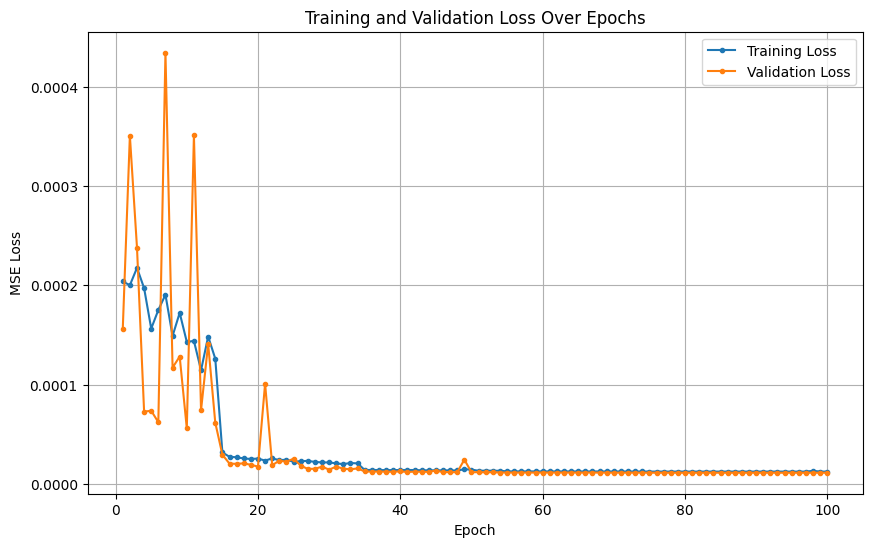

In [9]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='.')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='.')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

In [14]:
def predict_omega_phi_c(input_tensor, batch_size=1024):
    """
    Predicts omega and phi for either a single sample or full input tensor using the trained ANN model.

    Parameters:
    input_tensor (torch.Tensor): Shape (5,) for a single sample, or (1e6, 5) for full data
    batch_size (int): Number of samples per batch for efficient processing (used for full tensor)

    Returns:
    tuple:
        - For single sample (shape (5,)): (omega, phi) as scalars
        - For full tensor (shape (1e6, 5)): (omega, phi) as tensors of shape (1e6,)
    """
    model.eval()

    # Check the shape of the input tensor
    if input_tensor.dim() == 1 and input_tensor.shape[0] == 5:
        # Single sample: shape (5,)
        # Reshape to (1, 5) for the model
        input_tensor = input_tensor.reshape(1, -1)  # Shape: (1, 5)

        # Move to CPU for scaling
        input_cpu = input_tensor.cpu()

        # Scale input
        input_scaled = X_scaler.transform(input_cpu)

        # Convert back to tensor and move to device
        input_scaled = torch.tensor(input_scaled, dtype=torch.float32).to(device)

        # Predict
        with torch.no_grad():
            output_scaled = model(input_scaled)

        # Move to CPU for inverse scaling
        output_cpu = output_scaled.cpu()

        # Inverse scale
        output_transformed = y_scaler.inverse_transform(output_cpu)

        # Convert back to tensor (on CPU)
        output_transformed = torch.tensor(output_transformed, dtype=torch.float32)

        # Convert log10(omega) back to omega and extract phi
        omega = output_transformed[0, 0]  # Scalar
        phi = output_transformed[0, 1]          # Scalar

        return omega.item(), phi.item()  # Return as Python scalars

    elif input_tensor.dim() == 2 and input_tensor.shape[1] == 5:
        # Full tensor: shape (1e6, 5)
        num_samples = input_tensor.shape[0]  # 1e6

        # Lists to store predictions
        omega_list = []
        phi_list = []

        # Process in batches
        for i in range(0, num_samples, batch_size):
            # Get the current batch
            batch = input_tensor[i:i + batch_size]  # Shape: (batch_size, 5)

            # Move to CPU for scaling
            batch_cpu = batch.cpu()

            # Scale input
            batch_scaled = X_scaler.transform(batch_cpu)

            # Convert back to tensor and move to device
            batch_scaled = torch.tensor(batch_scaled, dtype=torch.float32).to(device)

            # Predict
            with torch.no_grad():
                output_scaled = model(batch_scaled)

            # Move to CPU for inverse scaling
            output_cpu = output_scaled.cpu()

            # Inverse scale
            output_transformed = y_scaler.inverse_transform(output_cpu)

            # Convert back to tensor (on CPU)
            output_transformed = torch.tensor(output_transformed, dtype=torch.float32)

            # Convert log10(omega) back to omega and extract phi
            omega_batch =output_transformed[:, 0]  # Shape: (batch_size,)
            phi_batch = output_transformed[:, 1]          # Shape: (batch_size,)

            # Append to lists
            omega_list.append(omega_batch)
            phi_list.append(phi_batch)

        # Concatenate all batches
        omega = torch.cat(omega_list, dim=0)  # Shape: (1e6,)
        phi = torch.cat(phi_list, dim=0)      # Shape: (1e6,)

        return omega, phi

    else:
        raise ValueError(f"Expected input shape (5,) or (N, 5), got {input_tensor.shape}")

In [15]:
predict_omega_phi_c(X_raw[0])

(-7.203105449676514, 0.9221028685569763)

In [17]:
y_transformed[0]

tensor([-7.2080,  0.9654], device='cuda:0')

In [23]:
for i in range(5,30,2):
  print(predict_omega_phi_c(X_raw[i]),y_transformed[i])

(-7.278140068054199, 10.53641128540039) tensor([-7.2790, 10.5618], device='cuda:0')
(-7.253994941711426, 9.720613479614258) tensor([-7.2526,  9.7128], device='cuda:0')
(-9.929645538330078, 0.39309075474739075) tensor([-9.9302,  0.3935], device='cuda:0')
(-9.916400909423828, 0.9836627244949341) tensor([-9.9154,  0.9958], device='cuda:0')
(-8.708389282226562, 0.7987698912620544) tensor([-8.7061,  0.7922], device='cuda:0')
(-7.229059219360352, 1.6769230365753174) tensor([-7.2283,  1.6838], device='cuda:0')
(-9.099663734436035, 0.9277474880218506) tensor([-9.0981,  0.9413], device='cuda:0')
(-7.318265914916992, 1.2763839960098267) tensor([-7.3190,  1.2604], device='cuda:0')
(-8.775774955749512, 0.513117253780365) tensor([-8.7797,  0.5144], device='cuda:0')
(-9.1481294631958, 1.0817070007324219) tensor([-9.1478,  1.0795], device='cuda:0')
(-7.006573677062988, 8.65665340423584) tensor([-7.0080,  8.6625], device='cuda:0')
(-9.421163558959961, 0.11650700867176056) tensor([-9.4207,  0.1122], de

In [24]:
# store data points
import os
outdir="ANN_ODE_CIRC_t2"
os.makedirs(outdir, exist_ok=True)


import joblib

# Save scalers
joblib.dump(X_scaler, f"{outdir}/X_scaler.pkl")
joblib.dump(y_scaler, f"{outdir}/y_scaler.pkl")

torch.save(model.state_dict(), f"{outdir}/model_weights.pth")
torch.save(model, f"{outdir}/model_full.pth")

In [34]:
from google.colab import files
import os, shutil

def zip_and_download(outdir="ANN_ODE_CIRC_t2"):
    """
    Zips the current directory into <outdir>.zip and downloads it.
    Excludes .ipynb_checkpoints and sample_data folders (common in Jupyter/Colab).

    Parameters:
    - outdir (str): Desired name of the zip file (without .zip extension)
    """
    zip_filename = f"{outdir}.zip"
    sample_data_path = './sample_data'
    if os.path.exists(sample_data_path):
        shutil.rmtree(sample_data_path)
        print("Removed sample_data directory")

    # Remove existing zip if present
    if os.path.exists(zip_filename):
        os.remove(zip_filename)

    # Create the zip archive, excluding .ipynb_checkpoints and sample_data
    !zip -r $zip_filename .

    # Download the zip file
    files.download(zip_filename)

# Step 3: Call the function to zip and download
zip_and_download(outdir="ANN_ODE_CIRC_t2")

  adding: .config/ (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2025.04.30/ (stored 0%)
  adding: .config/logs/2025.04.30/13.36.50.566118.log (deflated 58%)
  adding: .config/logs/2025.04.30/13.36.58.979052.log (deflated 86%)
  adding: .config/logs/2025.04.30/13.36.29.848398.log (deflated 93%)
  adding: .config/logs/2025.04.30/13.37.09.510583.log (deflated 56%)
  adding: .config/logs/2025.04.30/13.37.00.207659.log (deflated 58%)
  adding: .config/logs/2025.04.30/13.37.08.828246.log (deflated 57%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_update_check.json (deflated 23%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/default_configs.db (deflated 98%)
  adding: .config/configurations/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
zip_and_download(outdir="ANN_ODE_CIRC_t2")

  adding: .config/ (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2025.04.30/ (stored 0%)
  adding: .config/logs/2025.04.30/13.36.50.566118.log (deflated 58%)
  adding: .config/logs/2025.04.30/13.36.58.979052.log (deflated 86%)
  adding: .config/logs/2025.04.30/13.36.29.848398.log (deflated 93%)
  adding: .config/logs/2025.04.30/13.37.09.510583.log (deflated 56%)
  adding: .config/logs/2025.04.30/13.37.00.207659.log (deflated 58%)
  adding: .config/logs/2025.04.30/13.37.08.828246.log (deflated 57%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_update_check.json (deflated 23%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/default_configs.db (deflated 98%)
  adding: .config/configurations/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>